# How much data do you need for a classification analysis?
## Q2: How much data do you need to avoid a false positive?
##### Leyla Tarhan
##### ltarhan@g.harvard.edu
##### 7/2020

### Say you want to use classification to detect whether there's a difference between two categories in your data. For example, do demographics differ between people who do and don't develop COVID-19? Or, does a brain region respond differently when we see big and small objects? When we run these analyses, how much data do you need to collect per category? 

### Here, I'm taking a simulation-based approach to ask the second of two questions: 

### Q2. How much data do you need to avoid detecting a difference that isn't real?
#### As for Q1, I'll make a few assumptions:
1. There is NO real difference between the categories
2. As for Q1, I'll draw data from 100 dimensions (where 1 dimension = 1 kind of demographic information in the COVID example, or one brain voxel in the cognitive neuroscience example)
5. As for Q1, the data for each category are normally distributed (with some offset) in 100-dimensional space

Again, I'll iteratively draw a random sample from each "category," and do 2-way classification with sample sizes ranging from 10-100 points per category. This time, the result will be a plot of the average classifiction accuracy (which should be at chance, given that there's no real difference between these categories) for each sample size. This can be interpreted as the detection rate for false positives (an apparent difference when there is none).

In [2]:
## clean up

try:
    from IPython import get_ipython
    get_ipython().magic('clear')
    get_ipython().magic('reset -f')
except:
    pass


## Set-up

In [3]:
## import libraries

# !pip install -U scikit-learn
# !pip install opencv-python

# data wrangling:
import numpy as np
import pandas as pd
import itertools
import statistics
import math
from copy import deepcopy as dc
from scipy.spatial import distance
from scipy import stats

# plotting:
import matplotlib.pyplot as plt
import seaborn as sns

# SVM:
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import cv2



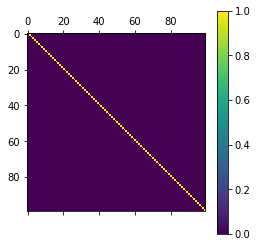

In [4]:
## General Setup

# data
nVox = 100 # number of voxels (or other dimensions)
sd = 1 # standard deviation of the distributions (keeping this the same for all distributions)
nIters = 100 # how many times you sample data of each size
nCats = 2 # how many categories you're classifying 

# training-testing split for classification analyses:
trainProp = .8 # 80% of data in each category used for training
testProp = .2 # 20% used for testing

# possible sample sizes
minN = 10
maxN = 100
nRange = range(minN, maxN+1)

# set up variance-covariance matrix for the multi-variate normal distributions:
covMat = np.identity(nVox)*sd**2 # orthogonal dimensions; main diagonal = s.d.^2 (variance)
# plot it to check -- main diagonal should = sd^2, all other values should = 0
plt.matshow(covMat);
plt.colorbar()
plt.show()

# decision boundary for considering classification accuracies to be significant:
maxP = 0.001;


# seed a random number generator:
np.random.seed(444)

In [5]:
## setup for this section

# multi-variate means for the 2 categories' activation distributions (making them equivalent now):
popMeans_q2 = [1, 1]

# to estimate the size of this difference, calculate the euclidean distance 
# between the means and then scale that by the standard deviation of the distributions
# (intuitively: a larger standard deviation = closer distributions if you don't change the means)

def calcDist(meansVec):
    # numerator: euclidean distance between mean vectors:
    m1 = [meansVec[0] for d in range(nVox)]
    m2 = [meansVec[1] for d in range(nVox)]
    d = distance.euclidean(m1, m2)
    
    # denominator: variance of the distributions (which is set up to be the same for both distributions):
    var = sd**2
    
    return d/var

dist = calcDist(popMeans_q2)
print('Q2: estimated distance between groups = ' + str(dist))
# sanity check.

Q2: estimated distance between groups = 0.0


## Simulations

In [6]:
## sample the data & classify the categories

# display progress:
from IPython.display import clear_output
clear_output(wait=True)
print('Simulations: comparing data with the same distribution.')

# set up the multivariate means for each category:
cat1Means_q2 = np.full((nVox), popMeans_q2[0]) # length = # voxels (dimensions)
cat2Means_q2 = np.full((nVox), popMeans_q2[1]) 

# loop through the sample sizes
accuracyDict_q2 = {}
accuracyDictScram_q2 = {}

for n in nRange:
    print('Estimating classification accuracy with ' + str(n) + ' samples / category...')
    currAccuracy = [] # set up an array to store classification accuracy for this sample size
    currAccuracyScram = [] # set up an array to store classification accuracy for scrambled data with this sample size
    
    # loop through the iterations for this sample size
    for i in range(nIters):
        
        # sample from both categories:
        cat1Patterns_q2 = np.random.multivariate_normal(cat1Means_q2, covMat, n) # category 1: sample size x voxels
        cat2Patterns_q2 = np.random.multivariate_normal(cat2Means_q2, covMat, n) # category 2: sample size x voxels

        # put the categories together:
        allCatsPatterns_q2 = np.concatenate((cat1Patterns_q2, cat2Patterns_q2)) # sample size * 2 categories x voxels

        # set up the labels for the classifier:
        labels = []
        for c, s in itertools.product(range(nCats), range(n)):
            labels.append(c)

        # make sure the data are in the expected size:
        assert len(labels) == allCatsPatterns_q2.shape[0], 'mismatch between labels length and patterns size'
        assert len(labels) == n*nCats, 'unexpected label length (should be sample size x categories)'
        assert allCatsPatterns_q2.shape[1] == nVox, 'unexpected patterns size (should be sample size*categories x voxels)'

        # partition the data into train / test subsets:
        (trainPatterns, testPatterns, trainLabels, testLabels) = train_test_split(allCatsPatterns_q2, labels, test_size = testProp, random_state=42)

        # train the classifier:
        model = LinearSVC(dual=False) # setting dual = false helps the algorithm converge faster
        model.fit(trainPatterns, trainLabels)

        # test the classifier:
        predictions = model.predict(testPatterns) # predicted labels for the held-out data

        # calculate accuracy (% of testing data that was correctly classified)
        comparisonVec = []
        comparisonVec = [predictions[e] == testLabels[e] for e in range(len(predictions))]
        comparisonVec = list(map(int, comparisonVec))
        currAccuracy.append(sum(comparisonVec)/len(comparisonVec))
        
        # --------------------------------------------------------------------
        # Scrambled baseline
        scramPatterns = dc(allCatsPatterns_q2)
        np.random.shuffle(scramPatterns) # shuffle the rows, keeping the labels intact
        (trainScramPatterns, testScramPatterns, trainScramLabels, testScramLabels) = train_test_split(scramPatterns, labels, test_size = testProp)
        modelScram = LinearSVC(dual=False) # set up the SVM
        modelScram.fit(trainScramPatterns, trainScramLabels) # train the SVM
        predictionsScram = model.predict(testScramPatterns) # test the SVM
        
        comparisonVecScram = []
        comparisonVecScram = [predictionsScram[e] == testScramLabels[e] for e in range(len(predictionsScram))]
        comparisonVecScram = list(map(int, comparisonVecScram))
        currAccuracyScram.append(sum(comparisonVecScram)/len(comparisonVecScram))


    # after looping through the iterations for this sample size, add the array to a dictionary
    accuracyDict_q2[n] = currAccuracy
    accuracyDictScram_q2[n] = currAccuracyScram
    assert len(currAccuracy) == nIters, 'accuracy isn''t being stored with expected length.'
    assert len(currAccuracyScram) == nIters, 'scrambled accuracy isn''t being stored with expected length.'

# after looping through all the sample sizes, result = a dictionary with classification accuracies across iterations for every sample size.
print('DONE with simulations!')

Simulations: comparing data with the same distribution.
Estimating classification accuracy with 10 samples / category...
Estimating classification accuracy with 11 samples / category...
Estimating classification accuracy with 12 samples / category...
Estimating classification accuracy with 13 samples / category...
Estimating classification accuracy with 14 samples / category...
Estimating classification accuracy with 15 samples / category...
Estimating classification accuracy with 16 samples / category...
Estimating classification accuracy with 17 samples / category...
Estimating classification accuracy with 18 samples / category...
Estimating classification accuracy with 19 samples / category...
Estimating classification accuracy with 20 samples / category...
Estimating classification accuracy with 21 samples / category...
Estimating classification accuracy with 22 samples / category...
Estimating classification accuracy with 23 samples / category...
Estimating classification accuracy

## Plot the results
### 1. average classification accuracy for each sample size
### 2. standard deviation of the classifier's performance for each sample size

Plotting average classification accuracy curve...


C:\Users\Leyla\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


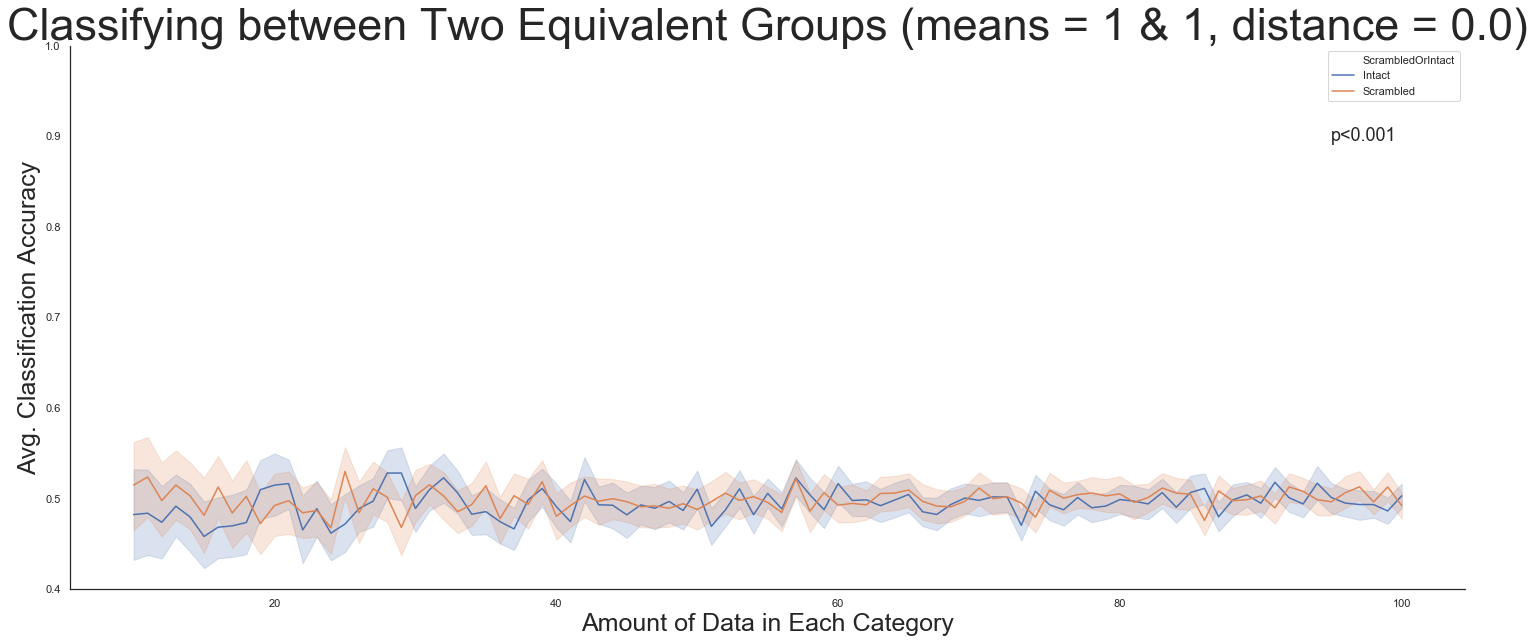

In [7]:
## plot average classification accuracy over sample sizes

print('Plotting average classification accuracy curve...')

# convert dictionary to dataframe (columns = sample sizes):
df_q2 = pd.DataFrame.from_dict(accuracyDict_q2) # convert dict to dataframe: columns = sample sizes
df_q2["iteration"] = df_q2.index

# melt it to long format (each row = one accuracy measurement):
dfLong_q2 = pd.melt(df_q2, id_vars='iteration')
dfLong_q2.columns = ['iteration', 'sample size', 'classification accuracy']

# add scrambled-or-intact column:
dfLong_q2['ScrambledOrIntact'] = ['Intact']*dfLong_q2.shape[0]

# add scrambled data:
dfScram_q2 = pd.DataFrame.from_dict(accuracyDictScram_q2)
dfScram_q2["iteration"] = dfScram_q2.index

# melt it into long format:
dfScramLong_q2 = pd.melt(dfScram_q2, id_vars='iteration')
dfScramLong_q2.columns = ['iteration', 'sample size', 'classification accuracy']
dfScramLong_q2['ScrambledOrIntact'] = ['Scrambled']*dfScramLong_q2.shape[0]


# add scrambled to intact data
dfs_q2 = [dfLong_q2, dfScramLong_q2]
dfIntactScram_q2 = pd.concat(dfs_q2)


# plot it:
f1 = plt.figure(figsize=(25,10))
sns.set()
sns.set_style("white")
ax = sns.lineplot(x = 'sample size', y = 'classification accuracy', data = dfIntactScram_q2, hue = "ScrambledOrIntact")

# make it pretty:
yLowerBound = .4
plt.ylim(yLowerBound, 1)
sns.despine()
ax.set_xlabel('Amount of Data in Each Category',fontsize=25);
ax.set_ylabel('Avg. Classification Accuracy',fontsize=25);
ax.set_title('Classifying between Two Equivalent Groups (means = ' + str(popMeans_q2[0]) + ' & ' + str(popMeans_q2[1]) + ', distance = ' + str(dist) + ')', fontsize = 45);

# add in significance vs. chance:
printoutFlag = 0;
for n in nRange:
    # get the intact accuracies:
    intactDF = dfLong_q2.loc[dfLong_q2['sample size'] == n]
    intactAcc = intactDF['classification accuracy']

    # get the scrambled accuracies:
    scramDF = dfScramLong_q2.loc[dfScramLong_q2['sample size'] == n]
    scramAcc = scramDF['classification accuracy']

    # compare with independent-samples t-test:
    [t, p] = stats.ttest_ind(intactAcc, scramAcc)

    # if it's significant, add an asterisk:
    if p < maxP:
        ax.text(n, yLowerBound+.01, '*', 
            horizontalalignment = 'center', 
            verticalalignment = 'center',
            fontsize = 30
           )
        if printoutFlag == 0:
            # print out the first significant sample size:
            print('First significant sample size (p<' + str(maxP) + '): ' + str(n) + ', t(' + str(nIters*2-2) + ') = ' + str(t))
            printoutFlag = 1;

# add in a label for interpreting the asterisks:
ax.text(max(nRange)-5, 0.9, 'p<'+str(maxP),
       horizontalalignment = 'left',
       verticalalignment = 'center',
       fontsize = 18
       );

# save the figure:
figName = 'Q2-distance' + str(dist) + '.png'
f1.savefig(figName, bbox_inches='tight')

plotting variance in the classifier's performance...


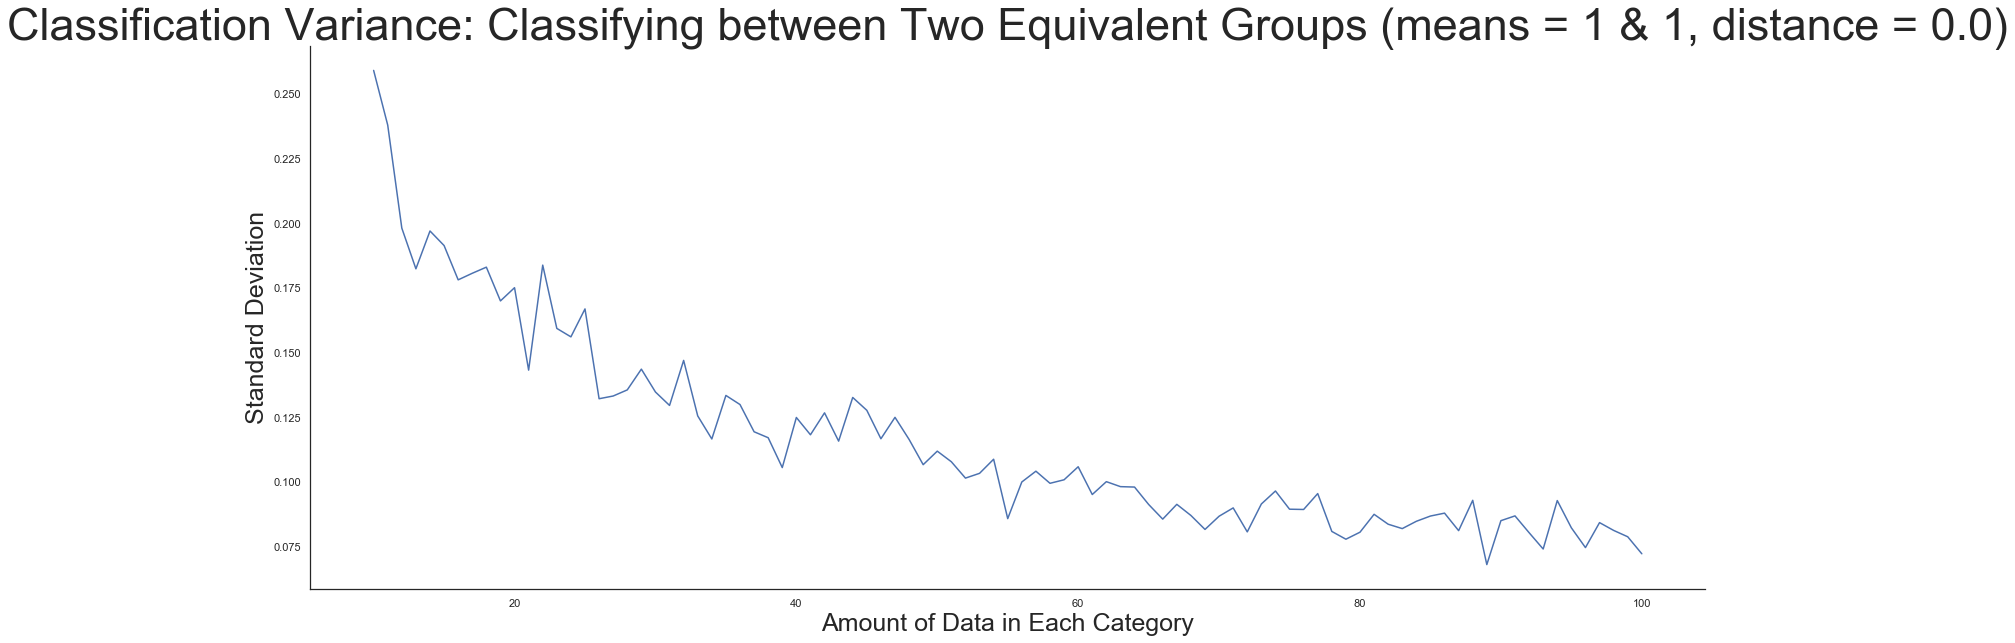

In [8]:
## plot standard deviation of the data at each sample size
# shows you how variable the results are, depending upon how much data you've analyzed
print("plotting variance in the classifier's performance...")

# calculate standard deviations:
sdVec = [statistics.stdev(df_q2[s]) for s in nRange]

# put it into a dataframe:
sdFrame = pd.DataFrame(sdVec, columns = ['StandardDeviation'])
sdFrame['SampleSize'] = [s for s in nRange]


# plot it:
f2 = plt.figure(figsize=(25,10))
sns.set()
sns.set_style("white")
ax = sns.lineplot(x = 'SampleSize', y = 'StandardDeviation', data = sdFrame)

# make it pretty:
sns.despine()
ax.set_xlabel('Amount of Data in Each Category',fontsize=25);
ax.set_ylabel('Standard Deviation',fontsize=25);
ax.set_title('Classification Variance: Classifying between Two Equivalent Groups (means = ' + str(popMeans_q2[0]) + ' & ' + str(popMeans_q2[1]) + ', distance = ' + str(dist) + ')', fontsize = 45);

# save it
f2FigName = 'Q2-SD.png'
f2.savefig(f2FigName, bbox_inches='tight')